In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from tmm_utils import *

#### Структуры: 

In [17]:
wl = 780.

Krechman_struct = {
    0: {'name': 'Среда', 'n': 1.5 + 0.j}, 
    1: {'name': 'ФК', 'N' : 10,
        'n1': 2.07+0.00001j,   'd1': 143.,
        'n2': 1.45 + 0.00001j, 'd2': 204.},
    2: {'name': 'Слой',  'n': 1.58+0.00001j, 'd': 0},
    3: {'name': 'Среда', 'n': 1. + 0.j}
}

Otto_struct ={
    0: {'name': 'Среда', 'n': 1.5 + 0.j},
    1: {'name': 'Слой',  'n': 1. + 0.j, 'd': 300},  
    2: {'name': 'Слой',  'n': 1.58 + 0.00001j, 'd': 0},
    3: {'name': 'ФК', 'N' : 10,
        'n1': 1.45 + 0.00001j, 'd1': 204.,
        'n2': 2.07 + 0.00001j, 'd2': 143.},
    4: {'name': 'Среда', 'n': 1.52 + 0.j }
}

Otto_bare ={
    0: {'name': 'Среда', 'n': 1.5 + 0.j},
    1: {'name': 'Слой',  'n': 1. + 0.j, 'd': 300},  
    2: {'name': 'ФК', 'N' : 10,
        'n1': 1.45 + 0.00001j, 'd1': 204.,
        'n2': 2.07 + 0.00001j, 'd2': 143.},
    3: {'name': 'Среда', 'n': 1.52 + 0.j }
}

Otto_struct2 ={
    0: {'name': 'Среда', 'n': 1. + 0.j},
    1: {'name': 'Слой',  'n': 1.58 + 0.00001j, 'd': 0},
    2: {'name': 'ФК', 'N' : 10,
        'n1': 1.45 + 0.00001j, 'd1': 204.,
        'n2': 2.07 + 0.00001j, 'd2': 143.},
    3: {'name': 'Среда', 'n': 1.52 + 0.j }
}

In [4]:
'''
This function generate n_eff array, 
Such if light falling from AIR on structure surface
In that case angles of incidence are imaginary value
'''

def generate_angles_from_n_eff(n_eff):
    print(type(n_eff))
    return np.arcsin(np.array(n_eff, dtype=np.complex)) * 180 / np.pi

WG_mode:  42.57999999999865 , BSW_mode:  46.63799999998919


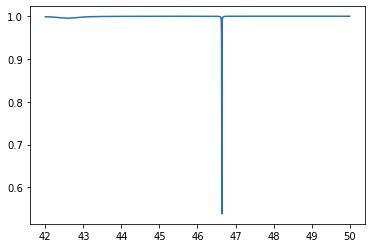

In [5]:
angl = np.arange(42, 50, 0.001)
R_angl = vectorize_R(angl, 780., Krechman_struct, 'TE')
plt.plot(angl, np.abs(R_angl))
ind1 = np.argmin(np.abs(R_angl)[angl < 43.])
ind2 = np.argmin(np.abs(R_angl))

def angle2n_eff(angle):
    return Krechman_struct[0]['n'] * np.sin(np.pi / 180 * angl[ind2])
print("WG_mode: ", angl[ind1],   ", BSW_mode: ", angl[ind2])

In [6]:
n_eff_angle = np.arcsin(np.complex(Krechman_struct[0]['n'] * np.sin(np.pi / 180 * angl[ind2])))
complex_angle_deg = n_eff_angle * 180 / np.pi
print(complex_angle_deg, generate_angles_from_n_eff(1.092))

<class 'float'>
(90+24.2017482072822j) (90+24.392523352787247j)


<class 'numpy.ndarray'>


/home/kwillum/tmm_utils.py:11: RuntimeWarning: divide by zero encountered in cdouble_scalars
  tm[0, 0] = (N2 + N1) / (2. * N2)
/home/kwillum/tmm_utils.py:12: RuntimeWarning: divide by zero encountered in cdouble_scalars
  tm[0, 1] = (N2 - N1) / (2. * N2)
/home/kwillum/tmm_utils.py:13: RuntimeWarning: divide by zero encountered in cdouble_scalars
  tm[1, 0] = (N2 - N1) / (2. * N2)
/home/kwillum/tmm_utils.py:14: RuntimeWarning: divide by zero encountered in cdouble_scalars
  tm[1, 1] = (N2 + N1) / (2. * N2)
/home/kwillum/tmm_utils.py:87: RuntimeWarning: invalid value encountered in cdouble_scalars
  return -(T[1, 0] / T[1, 1])


[41.8103149  41.81082737 41.81133984 ... 53.12819254 53.12882913
 53.12946574]


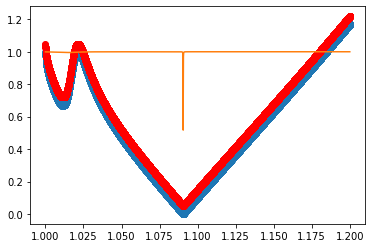

In [69]:
n_effs = np.arange(1.0, 1.2, 0.00001)
angls = generate_angles_from_n_eff(n_effs)
r_neffs = vectorize_R(-angls, 780., Otto_struct2, 'TE')
plt.plot(n_effs, abs(r_neffs), 'o')
tmp = np.empty(np.size(angls))
for i, a in enumerate(angls):
#     print(a)
    tmp[i] = abs(R_func(Otto_struct2, 780., a, 'TE')) + 0.05
plt.plot(n_effs, tmp, 'o', c='r')
new_angles = 180 / np.pi * np.arcsin(n_effs / Krechman_struct[0]['n'])
new_res = abs(vectorize_R(new_angles.real, 780., Krechman_struct, 'TE'))
plt.plot(n_effs, new_res)
print(new_angles.real)

In [70]:
from numba import njit
import numba
import copy
import time


def dict_to_arr(struct={}):
    n_array = []
    d_array = []
    for i in range(len(struct)):
        if struct[i]['name'] == 'Среда':
            n_array.append(struct[i]['n'])
        elif struct[i]['name'] == 'Слой':
            d_array.append(struct[i]['d'])
            n_array.append(struct[i]['n'])
        elif struct[i]['name'] == 'ФК':
            for j in range(int(struct[i]['N'])):
                d_array.append(struct[i]['d1'])
                d_array.append(struct[i]['d2'])
                n_array.append(struct[i]['n1'])
                n_array.append(struct[i]['n2'])
    return np.array(n_array, dtype=np.complex), np.array(d_array, dtype=np.float)

@njit
def calc_one_media(Z_range, X, k_xz, E_plus, E_minus, dk, angles, defocus_phase=1):
    r_pos = np.empty((1, 2), dtype=np.complex128)
    energy_part = np.empty((Z_range.size, X.size), dtype=np.float64)
    E_ordinary = np.empty((Z_range.size, X.size), dtype=np.complex128)
    for k, z_cur in enumerate(Z_range):
        r_pos[0, 1] = z_cur / 1000.
        for j, x in enumerate(X):
            r_pos[0, 0] = x
            E_forward = np.exp(1.0j * r_pos @ k_xz) *  E_plus.T * dk 
            r_pos[0, 1] *= -1
            E_backward = np.exp(1.0j * r_pos @ k_xz) * E_minus.T * dk
            r_pos[0, 1] *= -1
            E_flow = np.abs(np.sum((E_forward + E_backward) * np.sin(angles * np.pi / 180.)))
            E_full_ordinary = np.sum(E_forward + E_backward)
            P_flow_media = E_flow * np.abs(E_full_ordinary)
            energy_part[k, j] = P_flow_media / np.sqrt(np.pi / 2) / 1000
            E_ordinary[k, j] = E_full_ordinary
    return energy_part, E_ordinary

def get_struct_efficiency(alpha, X, struct, a=5, L=0, polar='TE', wl=780., eff=True):
    '''
    set default parameters range
    '''
    k = 2 * np.pi * 1.0e9 / wl * struct[0]['n']
    k_mkm = k / 1.0e6
    k_x = get_k_x(a=a, N_x=501, decr_times=20)
    s = spectral(a, k_x).reshape((-1, 1))
    if k_x.size < 2:
        dk = 1
    else:
        dk = k_x[1] - k_x[0]
    angles = 180 / np.pi * np.arcsin(k_x / k_mkm) + alpha
    R = vectorize_R(angles, wl, struct, polar).reshape((-1, 1))
    n_arr, d_arr = dict_to_arr(struct)
    for i, n_cur in enumerate(n_arr):
        if i == np.size(n_arr) - 2:
            break
        TMMs = generate_TMM(n_arr[0], n_arr[i], n_arr[i + 1], angles, polar)
        if i == 0:
            TMM_res = TMMs
        else:
            TMM_res = TMMs @ tmp
        k_mkm_gap = k_mkm / n_arr[0] * n_arr[i + 1]
        k_xz = get_K_xz_air(k_mkm, k_mkm_gap, angles) #k_mkm_gap - волновой вектор в текущей среде
        defocus_phase = 1. #get_defocus_phase(k_mkm, angles, L)
        E_plus, E_minus = E_air_spectrum(s, R, TMM_res)
        Z_range = np.arange(0, d_arr[i], 1)
        N_tmp = vectorize_N(n_arr[0], np.pi / 180 * angles, n_arr[i + 1])
        
        if (i == 0):
            efficiency_part, E_media = calc_one_media(Z_range, X, k_xz, E_plus, E_minus, dk, angles.real)
            E_full_struct = copy.deepcopy(E_media)
            efficiency = copy.deepcopy(efficiency_part)
        else:
            efficiency_part, E_media = calc_one_media(Z_range, X, k_xz, E_plus, E_minus, dk, angles.real)
            efficiency = np.vstack((efficiency, efficiency_part))
            E_full_struct = np.vstack((E_full_struct, E_media))           
        tmp = phase_shift_vec(d_arr[i] / 1000., N_tmp, k_mkm / n_arr[0]) @ TMM_res
    return np.sum(efficiency, axis=0), E_full_struct 

def calc_overlap_integral(field_dest, mode_field):
    mode_norm = np.sum(np.abs(mode_field) ** 2)
    field_norm = np.reshape(np.sum(np.abs(field_dest) ** 2, axis=0), (1, -1))
    overlap_eff = np.abs(np.conj(mode_field).T @ field_dest)**2 / field_norm / mode_norm
    return overlap_eff.reshape((-1, 1))



#     k0 = 2 * np.pi * 1.0e3 / wl    
#     angles = 180 / np.pi * np.arcsin((np.sin(alpha * np.pi / 180) * k0 + k_x * np.cos(alpha * np.pi / 180)) / k0)
#     print(np.sin(angles * np.pi / 180))

In [15]:
print(R_func(Otto_struct2, 780., complex_angle_deg, 'TE'))

(9.194582882305672e-05-0.0004564509480036427j)


In [34]:
%%time
X = np.arange(-10, 30, 1)
Otto_struct[1]['d'] = 0
resa, field = get_struct_efficiency(44, X, Otto_struct, a=5., L=0, polar='TE', wl=780.)
print(np.shape(resa))

(40,)
CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


In [35]:
print((field[:, 1] @ field[:, 1]))

(0.9842158864697503+3.723361946015687j)


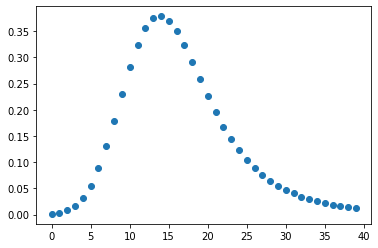

In [38]:
plt.plot(resa, 'o')

0.2143739031348945 13.0
0.20782117671347503 13.0
0.20107231487785968 13.0


KeyboardInterrupt: 

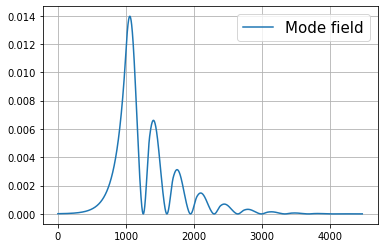

In [86]:
%%time
Otto_bare[1]['d'] = 3000
shift = 1000
_, raw_field = get_struct_efficiency(46.63799, np.array([0.]), Otto_bare, a=np.inf, L=0, polar='TE', wl=780.)
mode_field = raw_field[3000 - shift:]
plt.plot(np.abs(mode_field) ** 2, label='Mode field')
plt.legend(fontsize=15)
plt.grid()

X = np.arange(-10, 30, 1)
d = np.arange(0, 520, 20)
angles = np.arange(44, 49.1, 0.1)
eff_da = np.empty((d.size, angles.size), dtype=np.float64)
l_pos_da = np.empty((d.size, angles.size), dtype=np.float64)

for i, d_i in enumerate(d):
    for j, angle_j in enumerate(angles):
        Otto_bare[1]['d'] = d_i
        eff, field = get_struct_efficiency(angle_j, X, Otto_bare, a=5., L=0, polar='TE', wl=780.)
        ovrlap_eff = calc_overlap_integral(field, mode_field[shift - Otto_bare[1]['d']:])
        total_eff = overlap_integral * eff.reshape((-1, 1))
        eff_da[i, j] = np.max(total_eff)
        l_pos_da[i, j] = np.argmax(total_eff)
    print(i, ' / ', d.size)
# plt.plot(total_eff)

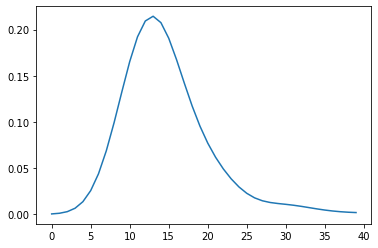

In [81]:
plt.plot(total_eff)

In [11]:
tres2 = copy.deepcopy(real_res)

(40,)
0.6903492226142487 0.0014712408281427466 0.0010156699619866885
0.7025676036633507 0.00386840411980117 0.0027178154124501415
0.7125235832733996 0.009375841034105646 0.006680507849822732
0.7196864109712078 0.020592497400232224 0.014820140546907055
0.7237502294042958 0.04097407562744186 0.02965499663499001
0.7246107268536539 0.07427512702319528 0.053820553779425
0.7222542267941654 0.1235318017675649 0.0892213659701227
0.7166767836517974 0.18980838329129882 0.1360312616473556
0.7078495309417389 0.27112698979109673 0.19191711254927343
0.6957175463599883 0.3620473153054666 0.25188266987054025
0.6802223896395825 0.45420065074451477 0.30895745202528724
0.6613447305024918 0.5377508908725618 0.35563871800158925
0.6391663413497586 0.6033917027245291 0.38566766703123845
0.6139486952648072 0.6442623118059505 0.39554400574155174
0.5862174663736499 0.6571868550312108 0.38525441309046354
0.5568284774756818 0.6429074013796979 0.35798914946810423
0.5269754797466936 0.605363967689269 0.319011967294

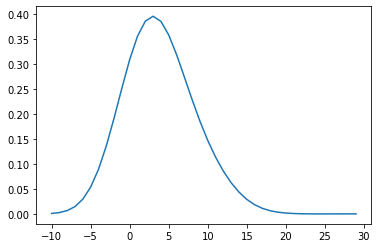

In [34]:
var1 = (tres[130:, 200])
norm1 = np.sum(abs(tres[130:, 200]) ** 2)
norm2 = np.sum(np.abs(tres2) ** 2, axis=0)
# print(np.shape(np.abs(tres2) ** 2))
print(np.shape(norm2))
var2 = (tres2)
# plt.plot(var1)

new = []

for i in range(np.shape(tres2)[1]):
#     print(var2[:, i])
    kp = norm2[i] * np.sin(44 * np.pi / 180.) / 1000. / 1.28
    miss = abs(np.sum(np.conj(var1) * var2[:, i])) ** 2 / norm1 / norm2[i]
    print(miss, kp, miss * kp)
    new.append(miss * kp)
plt.plot(np.arange(-10, 30), new)

/home/kwillum/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kwillum/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kwillum/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kwillum/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kwillum/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

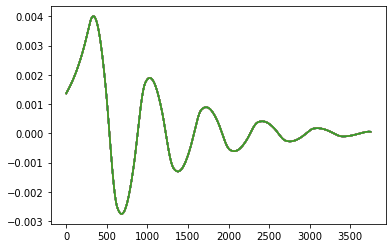

In [8]:
tres = copy.deepcopy(real_res[1720:])
for i in range(0, 450, 20):
    plt.plot(tres[:, i] / np.sum(tres[:, i]))
# max_arg = np.argmax(real_res[int(Otto_struct[1]['d'])])
# plt.plot(real_res[:,  max_arg], 'o', markersize=1)

In [ ]:
R_func(Otto_struct)

In [4]:
import copy

def prepare_array_structs(default_struct, array_parameters, param_num, param_name):
    structs_list = []
    for param in array_parameters:
        structs_list.append(copy.deepcopy(default_struct))
        structs_list[-1][param_num][param_name] = param
    return structs_list

def get_R_data(structure_array, array_parameters, angle_range, wavelength, polarisation, otto=False):
    R_abs = []
    R_arg = []
    R_min_val = []
    R_min_angle = []
    R_min_angle1 = []
    param_range1 = []
    param_range2 = []
    R_min_angle2 = []
    old_min = 0
    for i, struct in enumerate(structure_array):
        refl_coef = vectorize_R(angle_range, wavelength, struct, polarisation)
        R_abs.append(angle_range)
        R_arg.append(angle_range)        
        R_abs.append(np.abs(refl_coef))
        R_arg.append(np.angle(refl_coef))
        new_min = np.argmin(np.abs(refl_coef))
        if otto==False:
            if new_min > old_min:
                old_min = new_min
                R_min_angle.append(angle_range[new_min])
            elif len(R_min_angle1) == 0 or angle_range[new_min] >= R_min_angle1[-1]:
                old_min += np.argmin(np.abs(refl_coef[old_min:]))
                R_min_angle.append(angle_range[old_min])
                R_min_angle1.append(angle_range[new_min])
                param_range1.append(array_parameters[i])
            else:
                old_min += np.argmin(np.abs(refl_coef[old_min:]))
                R_min_angle.append(angle_range[old_min])
                R_min_angle2.append(angle_range[new_min])
                param_range2.append(array_parameters[i])
                tmp_1 = refl_coef[angle_range > R_min_angle1[-1]]
                tmp_min = np.argmin(np.abs(tmp_1)) + np.size(angle_range) - np.size(tmp_1)
                R_min_angle1.append(angle_range[tmp_min])
                param_range1.append(array_parameters[i])
        else:
            R_min_angle.append(angle_range[np.argmin(np.abs(refl_coef))])
        R_min_val.append(np.min(np.abs(refl_coef)))
    if otto==False:
        return R_arg, R_abs, [array_parameters, np.array(R_min_val)], [array_parameters, np.array(R_min_angle)], [np.array(param_range1), np.array(R_min_angle1)],[np.array(param_range2), np.array(R_min_angle2)]
    else:
        return R_arg, R_abs, [array_parameters, np.array(R_min_val)], [array_parameters, np.array(R_min_angle)]
        
    
    
def plot_dependencies(variation_array, var_name, n_prism=1.5, *args):
    graph_num = len(args[0])
    if graph_num > 6 or graph_num < 5:
        gr_size = graph_num
    else:
        gr_size = 4
    fig, ax = plt.subplots(1, gr_size, figsize=(5 * gr_size, 5))
    for i, ind in enumerate(range(1, len(args[0][0]), 2)):
        ax[0].plot(args[0][0][0], args[0][0][ind], label=str(variation_array[i]))
    ax[0].set_xlabel("angle")
    ax[0].set_ylabel("argR")  
    
    for i, ind in enumerate(range(1, len(args[0][1]), 2)):
        ax[1].plot(args[0][1][0], args[0][1][ind], label=str(variation_array[i]))
    ax[1].set_xlabel("angle")
    ax[1].set_ylabel("|R|")
    
    if graph_num > 2:
        ax[2].plot(args[0][2][0], args[0][2][1], 'o')
        ax[2].set_xlabel(var_name)
        ax[2].set_ylabel("$R_{min}$")  
        ax[2].grid()
    
    if graph_num > 3:
        [print("TE0: ", args[0][3][0][i], ": ", args[0][3][1][i]) for i in range(np.size(variation_array))]
        ax[3].plot(args[0][3][0], n_prism.real * np.sin(args[0][3][1] * np.pi / 180), 'o', label='TE0')
        ax[3].set_xlabel(var_name)
        ax[3].set_ylabel("$n_{eff}$")  
       
    if graph_num > 4:
        [print("TE1: ", args[0][4][0][i], ": ", args[0][4][1][i]) for i in range(np.size(args[0][4][0]))]
        ax[3].plot(args[0][4][0], n_prism.real * np.sin(args[0][4][1] * np.pi / 180), 'o', color='r', label='TE1')
    
    if graph_num > 5:
        [print("TE2: ", args[0][5][0][i], ": ", args[0][5][1][i]) for i in range(np.size(args[0][5][0]))]
        ax[3].plot(args[0][5][0], n_prism.real * np.sin(args[0][5][1] * np.pi / 180), 'o', color='g',  label='TE2')
        ax[3].grid()
        
    ax[0].legend()
    ax[1].legend()
    ax[3].legend()


#### Анализ в кречмане:

TE0:  0 :  46.638163816381635
TE0:  25 :  48.607660766076606
TE0:  50 :  50.80748074807481
TE0:  75 :  53.1013101310131
TE0:  100 :  55.4045404540454
TE0:  125 :  57.65606560656066
TE0:  150 :  59.82768276827683
TE0:  175 :  61.895889588958894
TE0:  200 :  63.865386538653866
TE0:  225 :  65.73617361736174
TE0:  250 :  67.51295129512951
TE0:  275 :  69.20982098209821
TE0:  300 :  70.84088408840884
TE0:  325 :  72.41084108410841
TE0:  350 :  73.93379337933794
TE0:  375 :  75.42854285428544
TE0:  400 :  76.91389138913891
TE0:  425 :  78.40394039403941
TE0:  450 :  79.93159315931592
TE0:  475 :  81.54855485548555
TE0:  500 :  83.33943394339434
TE0:  525 :  85.55805580558055
TE0:  550 :  85.55805580558055
TE1:  75 :  43.0
TE1:  100 :  43.0
TE1:  125 :  43.014101410141016
TE1:  150 :  43.07520752075207
TE1:  175 :  43.14101410141014
TE1:  200 :  43.23032303230323
TE1:  225 :  43.35723572357236
TE1:  250 :  43.57815781578158
TE1:  275 :  44.001200120012
TE1:  300 :  44.74857485748575
TE1:  32

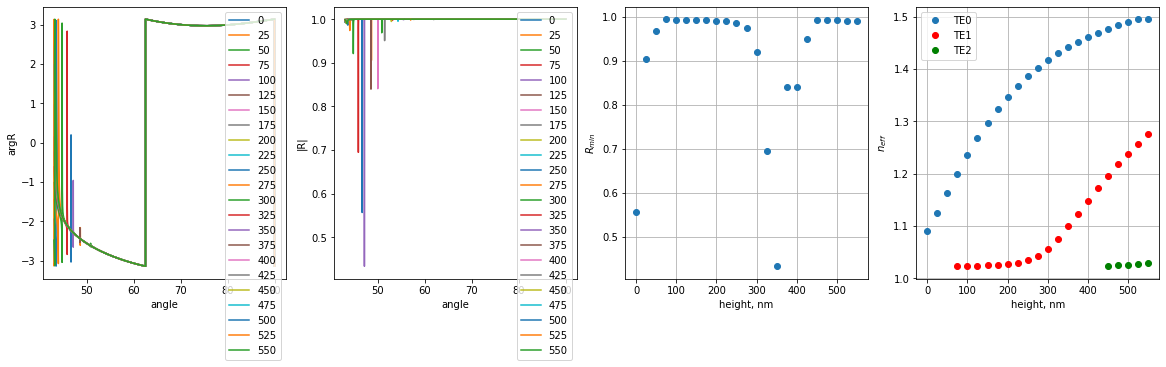

In [4]:
wg_heights = np.arange(0, 575, 25)
angles_range = np.linspace(43., 90., 10000)
struct_arr = prepare_array_structs(Krechman_struct, wg_heights, 2, 'd')
R_data = get_R_data(struct_arr, wg_heights, angles_range, wl, 'TE')
plot_dependencies(wg_heights, "height, nm", struct_arr[0][0]['n'], R_data)

In [13]:
R_data[3]

[array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
        325, 350, 375, 400, 425, 450, 475, 500, 525, 550]),
 array([46.63816382, 48.60766077, 50.80748075, 53.10131013, 55.40454045,
        57.65606561, 59.82768277, 61.89588959, 63.86538654, 65.73617362,
        67.5129513 , 69.20982098, 70.84088409, 72.41084108, 73.93379338,
        75.42854285, 76.91389139, 78.40394039, 79.93159316, 81.54855486,
        83.33943394, 85.55805581, 85.55805581])]

#### Анализ в Отто:

TE0:  50 :  80.0
TE0:  100 :  78.70987098709871
TE0:  150 :  77.6017601760176
TE0:  200 :  77.19371937193719
TE0:  250 :  77.02970297029702
TE0:  300 :  76.96169616961696
TE0:  350 :  76.93269326932693
TE0:  400 :  76.92069206920692
TE0:  450 :  76.91569156915692
TE0:  500 :  76.91369136913691
TE0:  550 :  76.91269126912691
TE0:  600 :  76.9116911691169
TE0:  650 :  76.9116911691169
TE0:  700 :  76.9116911691169
TE0:  750 :  76.9116911691169
TE0:  800 :  76.9116911691169
TE0:  850 :  76.9116911691169


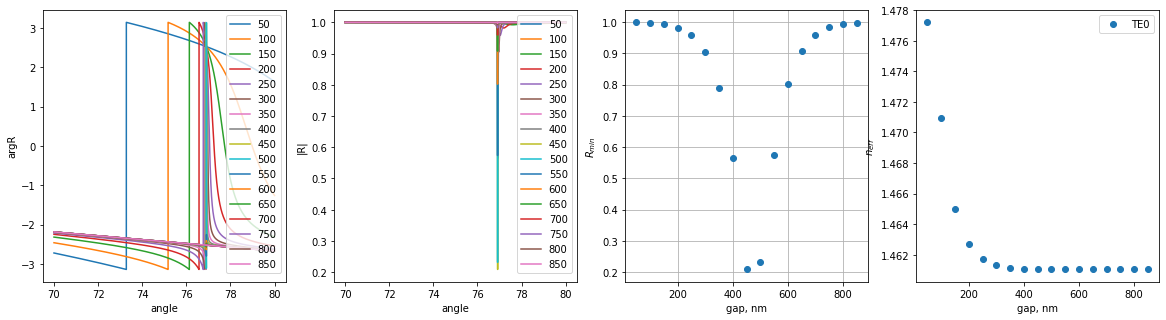

In [275]:
wg_height = 400
air_gaps = np.arange(50, 900, 50)
angles_range1 = np.linspace(70., 80., 10000)
Otto_struct[2]['d'] = wg_height
struct_arr1 = prepare_array_structs(Otto_struct, air_gaps, 1, 'd')
R_data1 = get_R_data(struct_arr1, air_gaps, angles_range1, wl, 'TE', otto=True)
plot_dependencies(air_gaps, "gap, nm", struct_arr[0][0]['n'], R_data1)

0


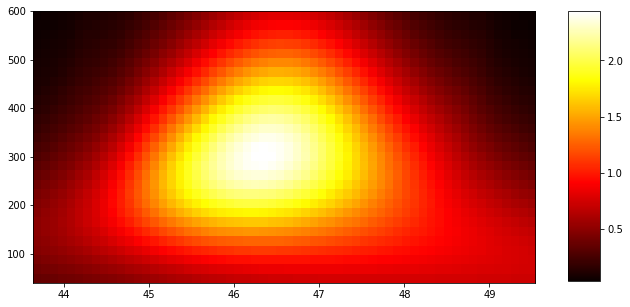

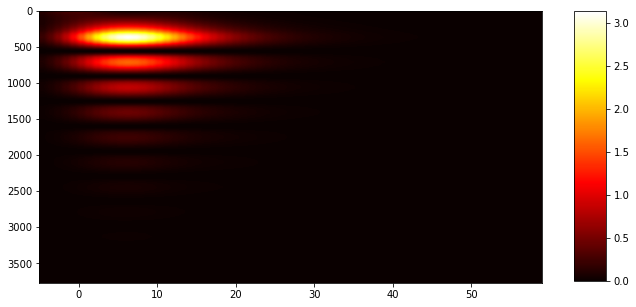

25


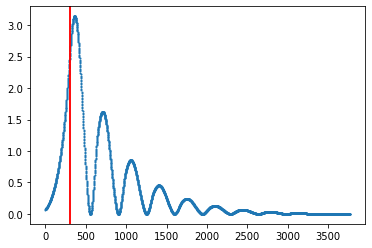

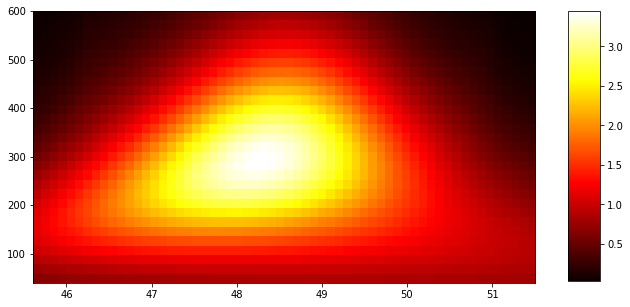

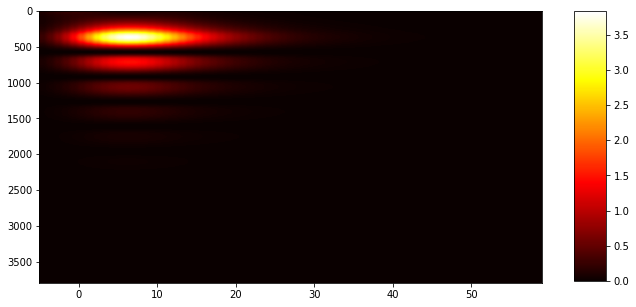

50


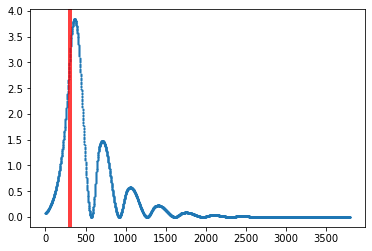

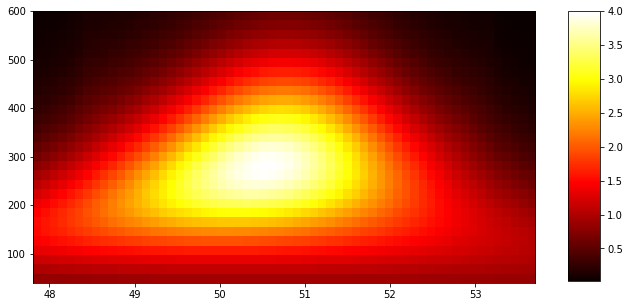

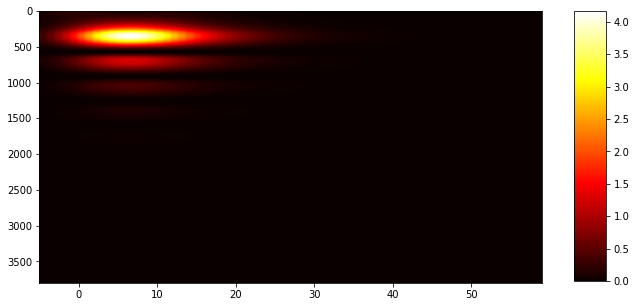

75


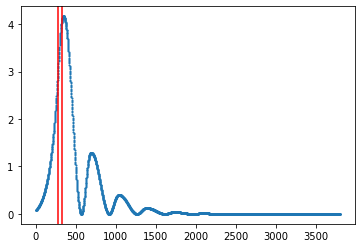

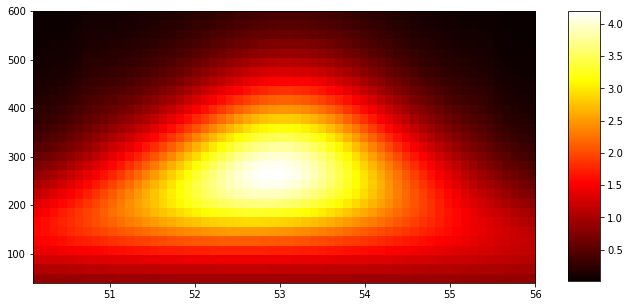

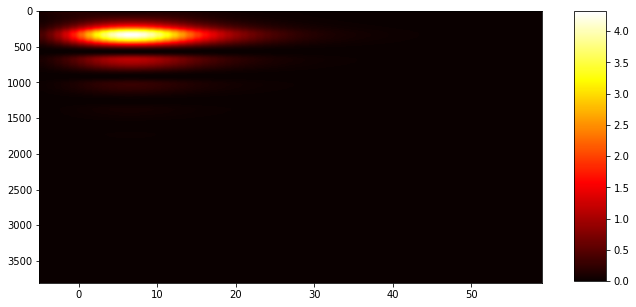

100


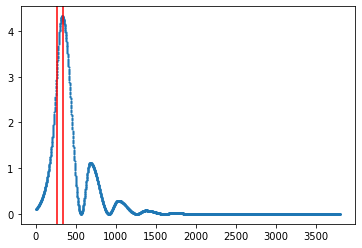

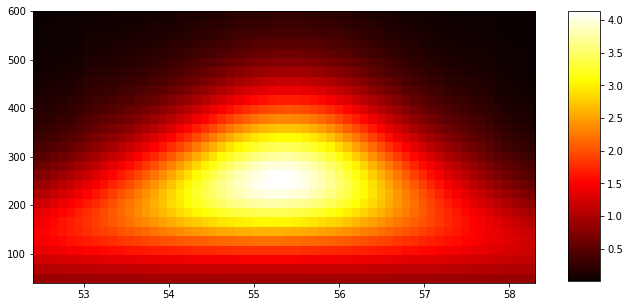

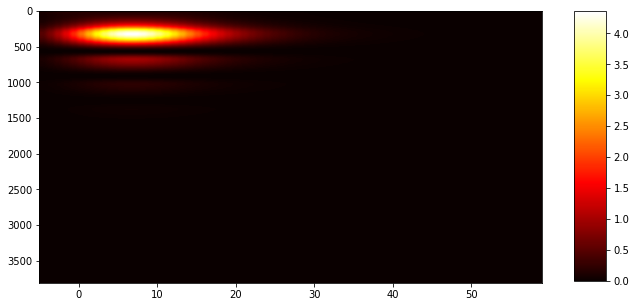

125


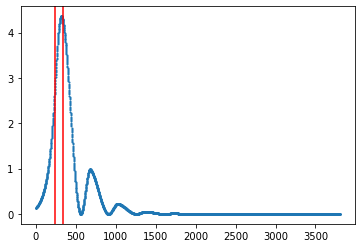

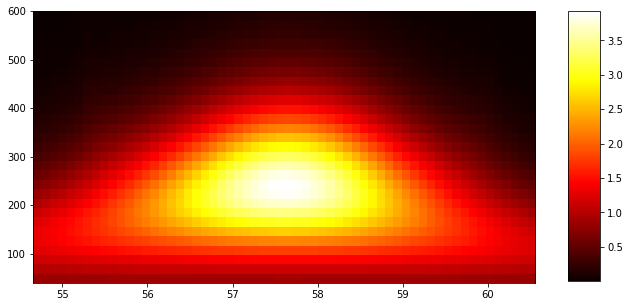

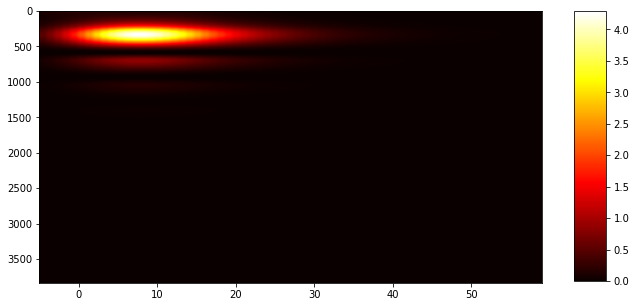

150


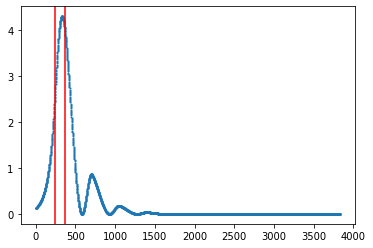

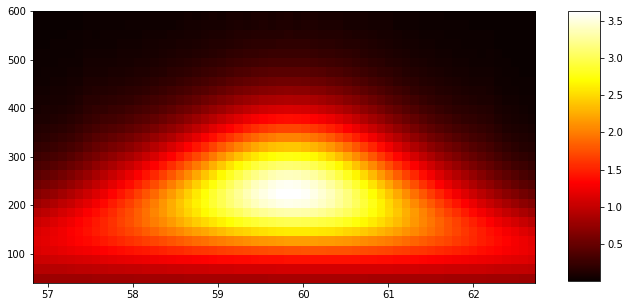

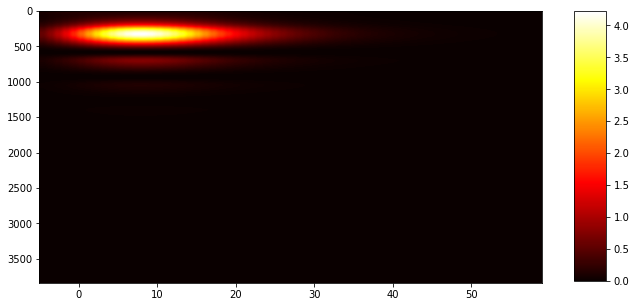

175


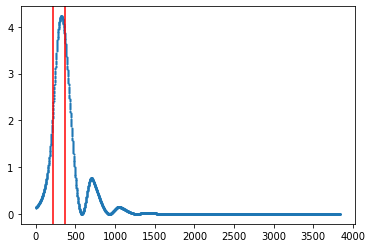

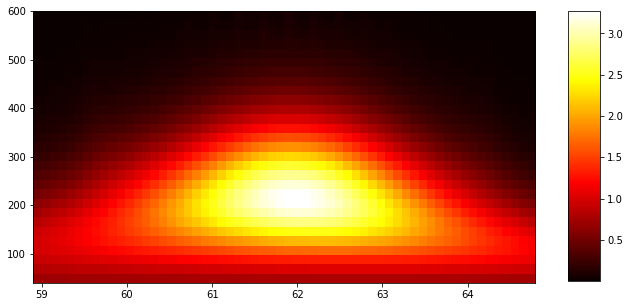

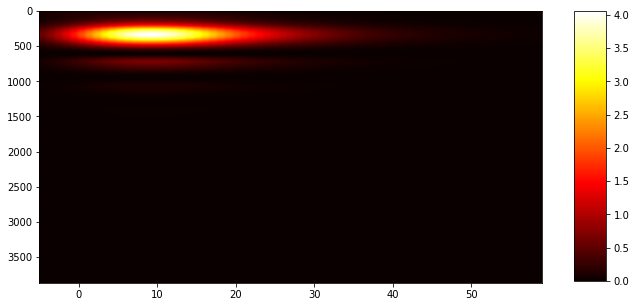

200


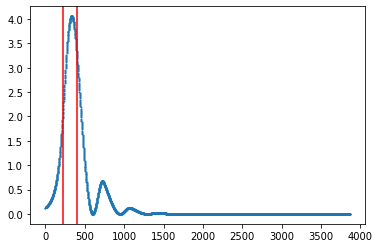

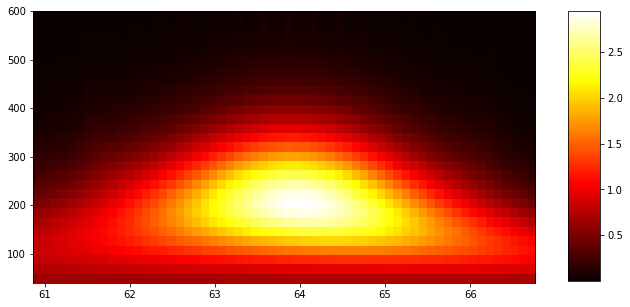

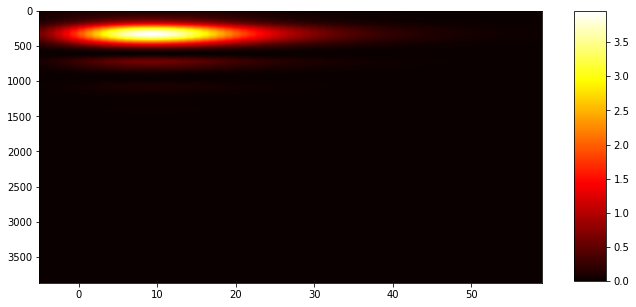

225


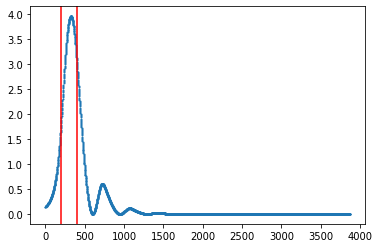

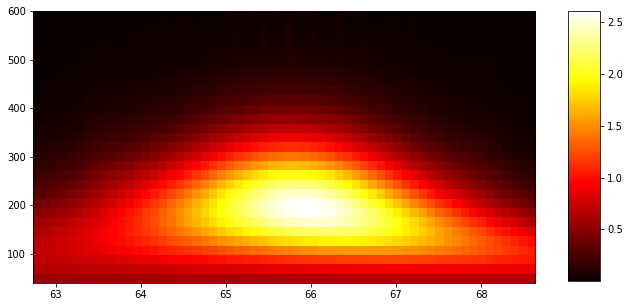

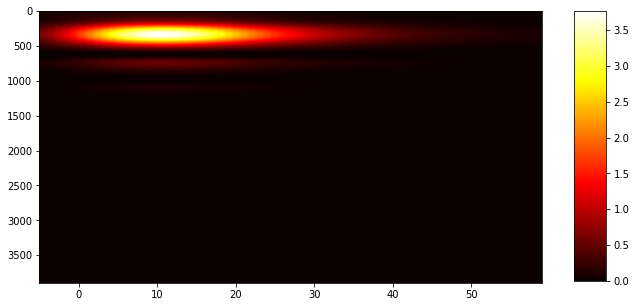

250


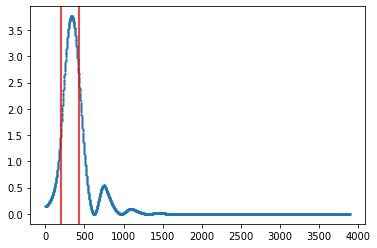

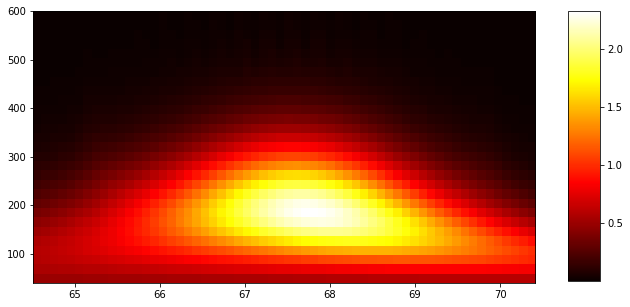

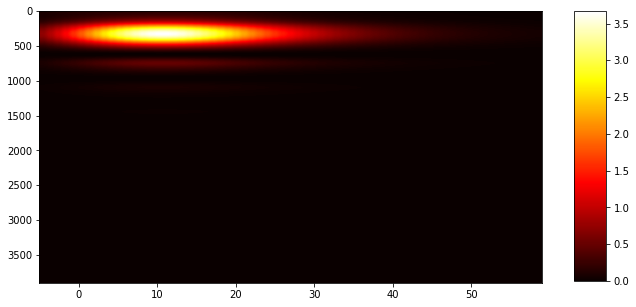

275


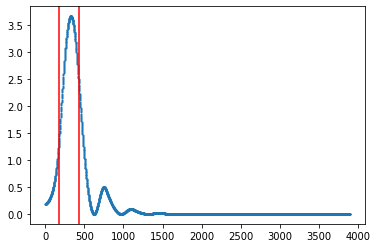

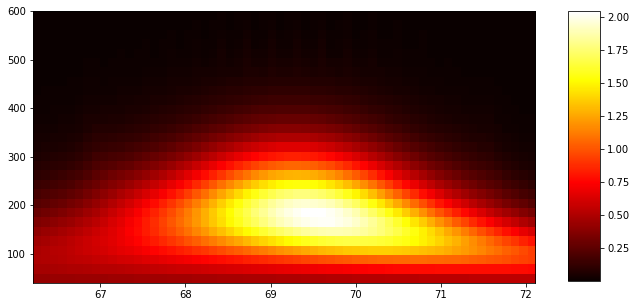

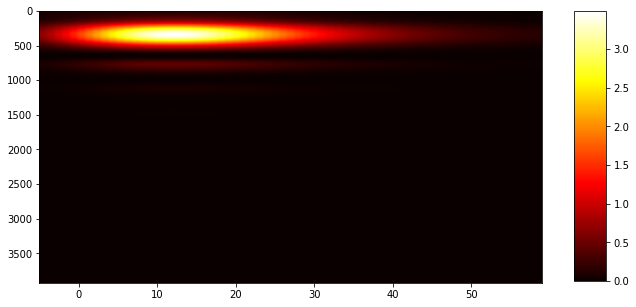

300


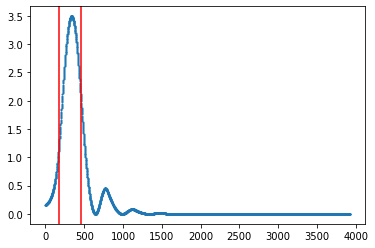

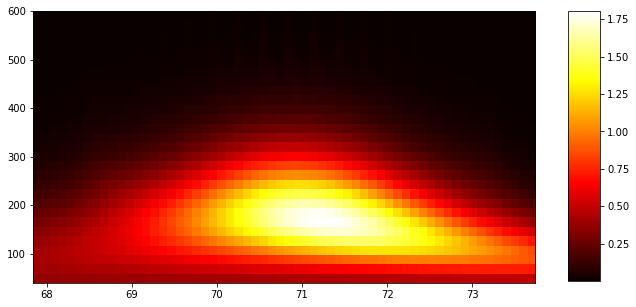

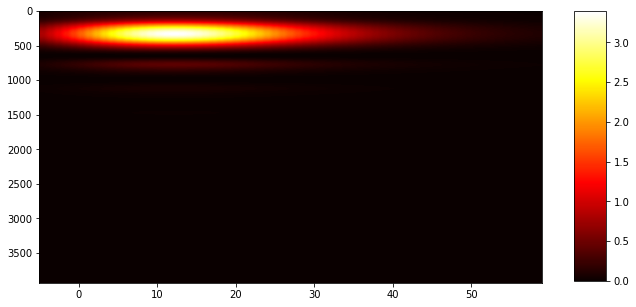

325


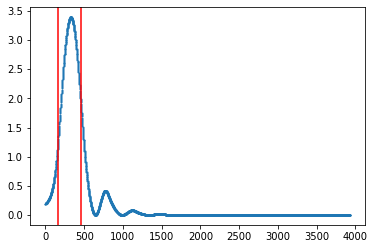

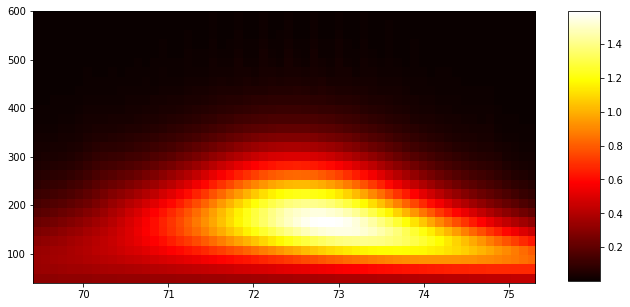

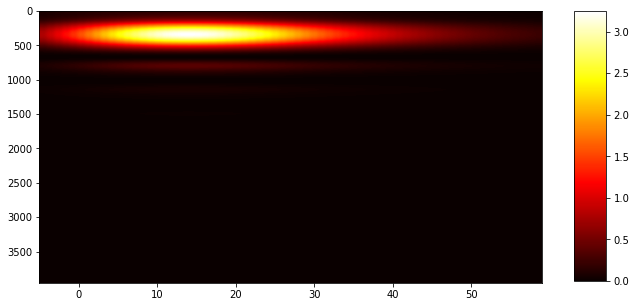

350


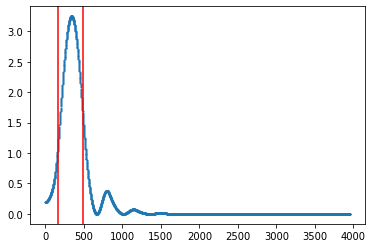

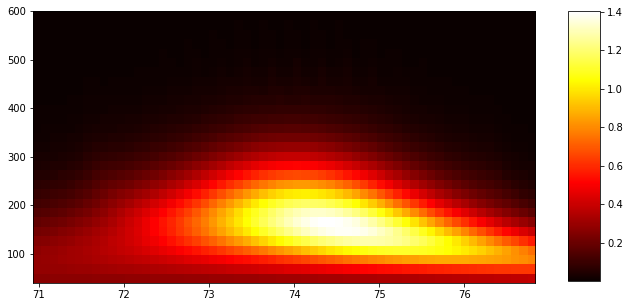

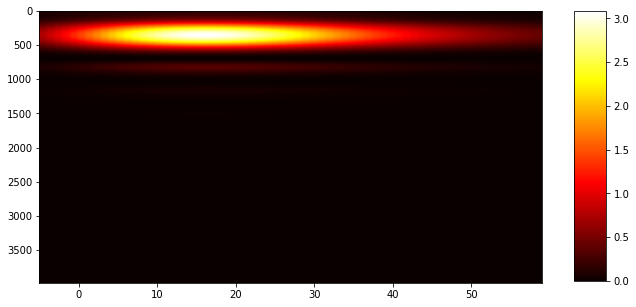

375


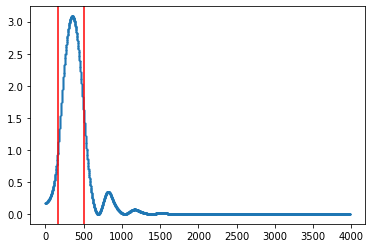

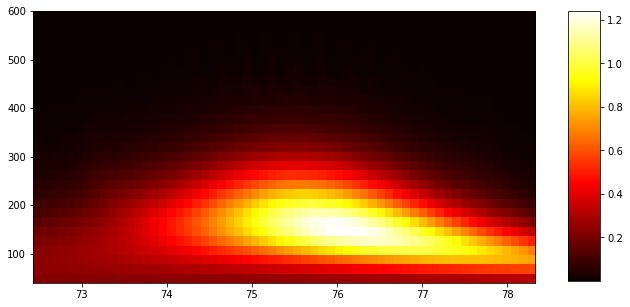

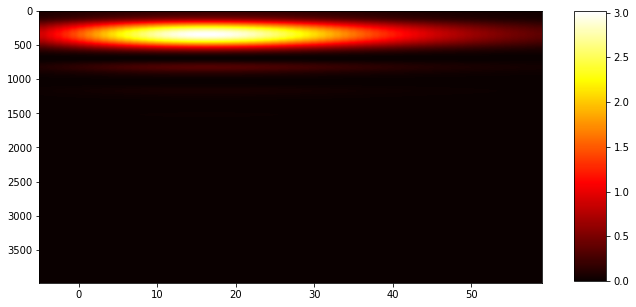

400


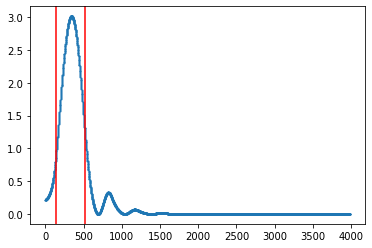

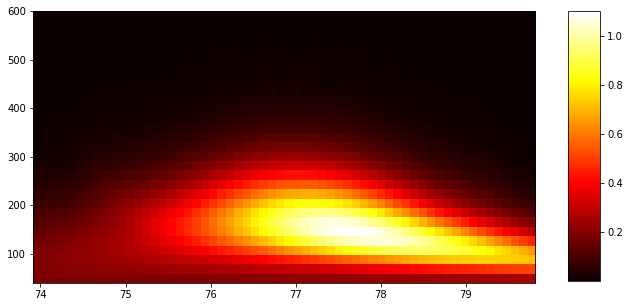

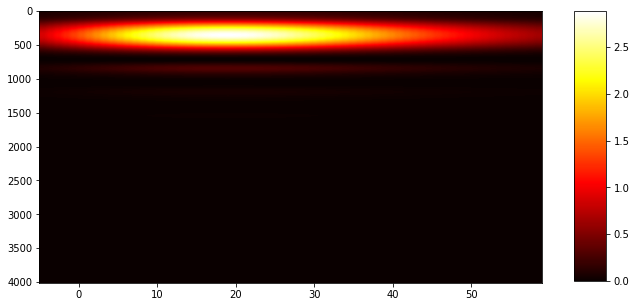

425


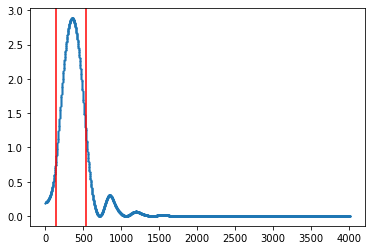

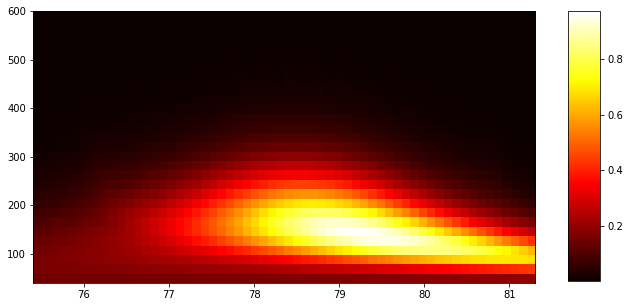

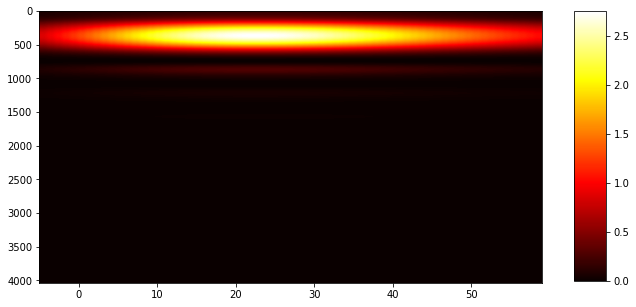

450


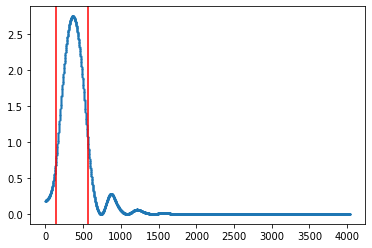

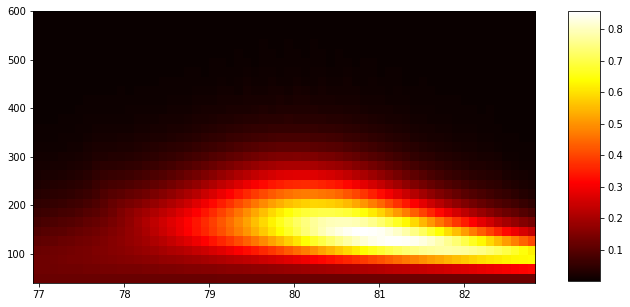

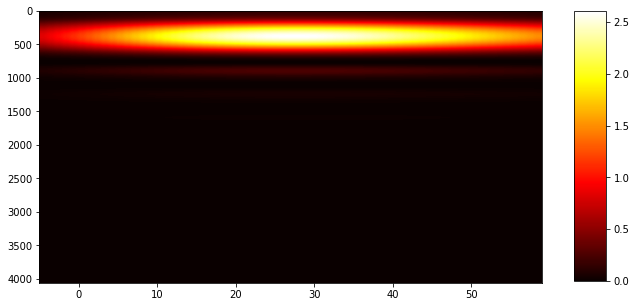

475


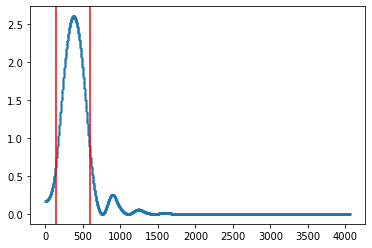

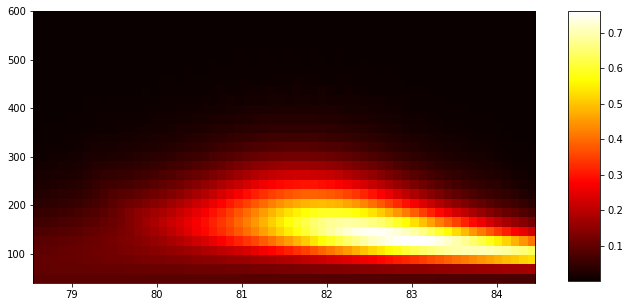

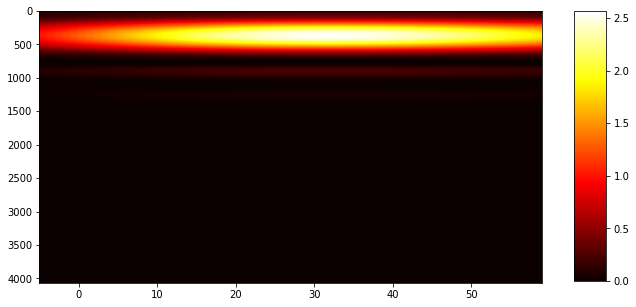

500


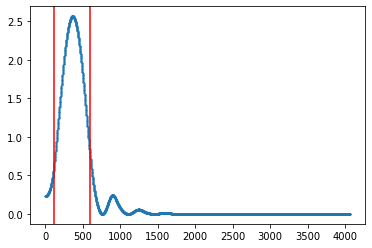

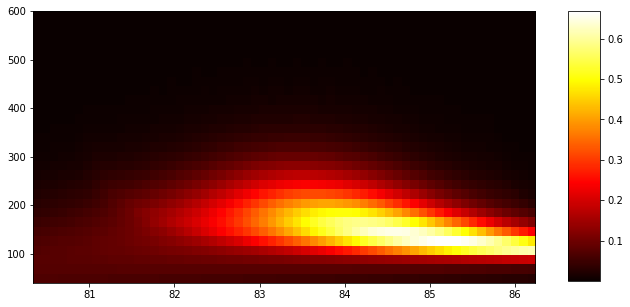

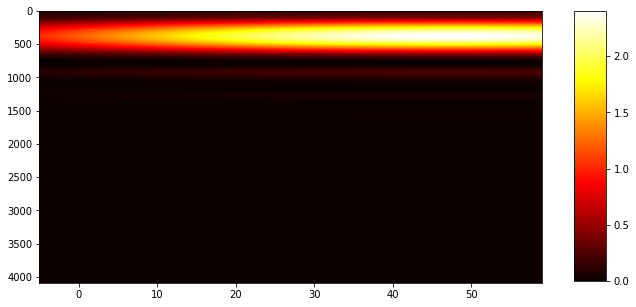

525


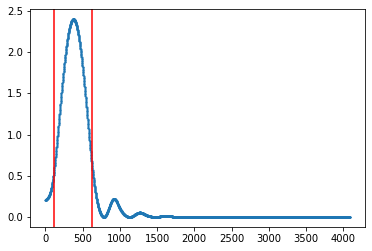

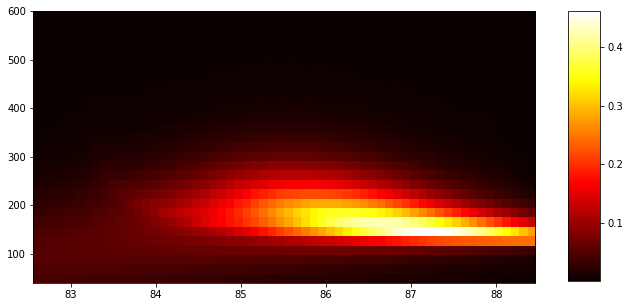

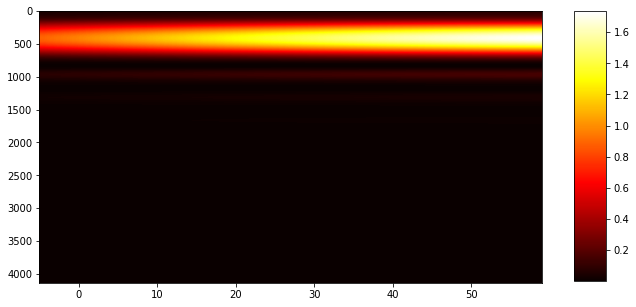

550


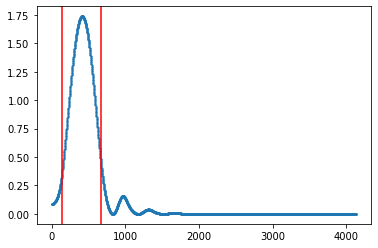

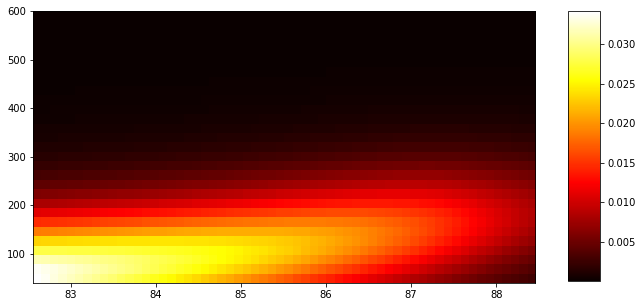

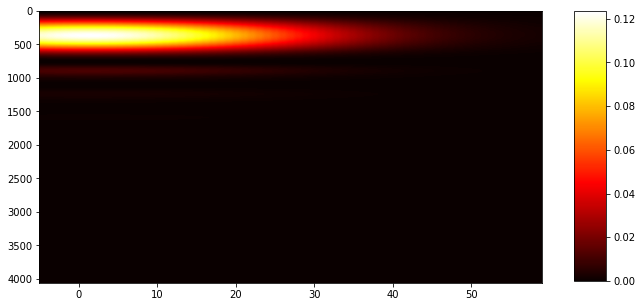

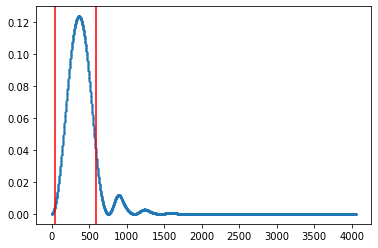

In [17]:
X = np.arange(-5, 60, 1)
full_data = []
for param in zip(R_data[3][0], R_data[3][1]):
    wg_height = param[0]
    angle = param[1]
    Otto_struct[2]['d'] = wg_height
    print(wg_height)
    cut_angles = np.arange(angle - 3., angle + 3., 0.1)
    gap_range = np.arange(40, 620, 20)
    shot = []
    E_slices = []
    for i, gap in enumerate(gap_range):
        Otto_struct[1]['d'] = gap
        E_slices.append(cut_BSW_intesity(cut_angles, X, Otto_struct, 5., 
                                         Otto_struct[1]['d'] / 1000, 0, polar="TE", wl=wl, plasmon=True))
    destr = np.empty((np.size(gap_range), np.size(cut_angles)))
    for i, E in enumerate(E_slices):
        I = np.abs(E) ** 2
        destr[i] = np.max(I, axis=1)
    shot.append(gap_range)
    shot.append(cut_angles)
    shot.append(destr)
    gap_max_ind = np.argmax(destr) // np.size(cut_angles)
    angle_max_ind = np.argmax(destr) % np.size(cut_angles)
    plot_2Dmap(destr, [cut_angles.min(), cut_angles.max(), gap_range.min(), gap_range.max()], isE=True)
    
    Otto_struct[1]['d'] = gap_range[gap_max_ind]
    Otto_struct[2]['d'] = wg_height
    res = cut_BSW_intesity_1(cut_angles[angle_max_ind], X, Otto_struct, a=5., L=0, polar='TE', wl=wl)
    real_res = np.array(res)
    sum_length = get_struct_height(Otto_struct)
    plot_2Dmap(real_res[::-1], [X.min(), X.max(), sum_length, 0], isE=True)

    max_arg = np.argmax(real_res[int(Otto_struct[1]['d'])])
    plt.plot(real_res[:,  max_arg], 'o', markersize=1)
    plt.axvline(x=Otto_struct[1]['d'], color='r')
    plt.axvline(x=Otto_struct[1]['d'] + Otto_struct[2]['d'], color='r')
    
    shot.append([gap_range[gap_max_ind], cut_angles[angle_max_ind], sum_length])
    shot.append(real_res[::-1])
    full_data.append(copy.deepcopy(shot))
    


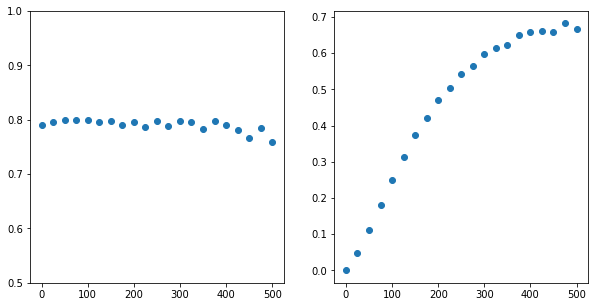

In [37]:
full_energy_PC = np.empty(len(full_data[:-2]), dtype=np.float)
wg_energy_PC = np.empty(len(full_data[:-2]), dtype=np.float)
for i, element in enumerate(full_data[:-2]):
    energy_flow = np.sum(element[4], axis=0)
    full_energy_PC[i] = np.max(energy_flow) * np.sin(element[3][1] * np.pi / 180) / 1000 / 1.28
    max_ind = np.argmax(energy_flow)
    energy_flow = np.sum(element[4][::-1][element[3][0]: element[3][0] + R_data[3][0][i], :], axis=0)
    wg_energy_PC[i] = np.max(energy_flow) * np.sin(element[3][1] * np.pi / 180) / 1000 / 1.28
    max_ind1 = np.argmax(energy_flow)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(R_data[3][0][:-2], full_energy_PC, 'o')
ax[0].set_ylim(bottom=0.5, top=1)
ax[1].plot(R_data[3][0][:-2], wg_energy_PC, 'o')

In [17]:
cut_angles = np.arange(54, 57, 0.1)
X = np.arange(-5, 35, 1)
cut_BSW_intesity(cut_angles, X, Otto_struct)

E_slices = []
gap_range = np.arange(100, 600, 40)
for i, gap in enumerate(gap_range):
    Otto_struct[1]['d'] = gap
    E_slices.append(cut_BSW_intesity(cut_angles, X, Otto_struct, 5., 
                                     Otto_struct[1]['d'] / 1000, 0, polar="TE", wl=wl, plasmon=False))
for i, E in enumerate(E_slices):
    print(gap_range[i])
    plot_2Dmap(E, [X.min(), X.max(), cut_angles.min(), cut_angles.max()])

SyntaxError: invalid syntax (<ipython-input-17-0d549c0626e6>, line 2)

In [6]:
def get_struct_height(struct):
    height = 0
    for i in range(1, len(struct) - 1):
        if struct[i]['name'] == 'Слой':
            height += struct[i]['d']
        elif struct[i]['name'] == 'ФК':
            height += (struct[i]['d1'] + struct[i]['d2']) * struct[i]['N']
    return height

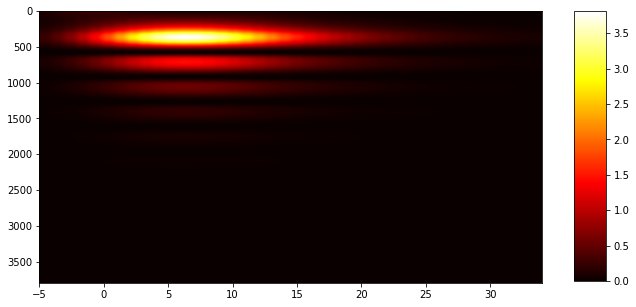

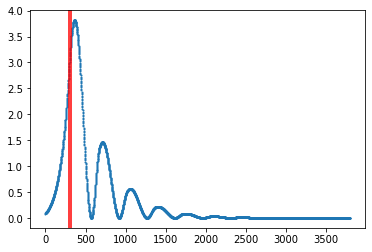

In [13]:
Otto_struct[1]['d'] = 300.
Otto_struct[2]['d'] = 25.
res = cut_BSW_intesity_1(48.4, X, Otto_struct, a=5., L=0, polar='TE', wl=wl)
real_res = np.array(res)
sum_arr = get_struct_height(Otto_struct)
plot_2Dmap(real_res[::-1], [X.min(), X.max(), sum_arr, 0], isE=True)


max_arg = np.argmax(real_res[int(Otto_struct[1]['d'])])
plt.plot(real_res[:,  max_arg], 'o', markersize=1)
plt.axvline(x=Otto_struct[1]['d'], color='r')
plt.axvline(x=Otto_struct[1]['d'] + Otto_struct[2]['d'], color='r')
#plt.imshow(real_res[::-1], cmap=plt.cm.inferno, origin='lower', aspect='auto')    

1359.6053383770711


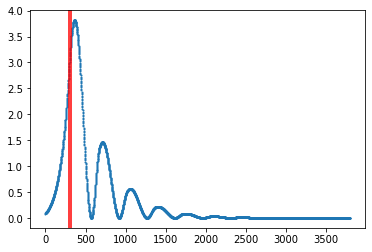

In [12]:
max_arg = np.argmax(real_res[int(Otto_struct[1]['d'])])
plt.plot(real_res[:,  max_arg], 'o', markersize=1)
plt.axvline(x=Otto_struct[1]['d'], color='r')
plt.axvline(x=Otto_struct[1]['d'] + Otto_struct[2]['d'], color='r')